In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/notebooks


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [3]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')

run id: 20241118_151603


In [4]:
# torch.cuda.empty_cache()
!nvidia-smi

Mon Nov 18 15:16:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:DA:00.0 Off |                  N/A |
|  0%   31C    P8              13W / 250W |      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
)

from sourcerer.likelihood_estimator import train_lml_source
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform, # a little slanted uniform to make log-density well defined
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores
from sourcerer.simulators import (
    InverseKinematicsSimulator,
    LotkaVolterraSimulator,
    SIRSimulator,
    SLCPSimulator,
    TwoMoonsSimulator,
    GaussianMixtureSimulator,
)
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)
from sourcerer.wasserstein_estimator import train_source

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [6]:
def get_simulator(cfg):
    if cfg.simulator.self == "two_moons":
        return TwoMoonsSimulator()
    elif cfg.simulator.self == "inverse_kinematics":
        return InverseKinematicsSimulator()
    elif cfg.simulator.self == "slcp":
        return SLCPSimulator()
    elif cfg.simulator.self == "sir":
        return SIRSimulator()
    elif cfg.simulator.self == "lotka_volterra":
        return LotkaVolterraSimulator()
    elif cfg.simulator.self == "gaussian_bimodal":
        return GaussianBimodalSimulator()
    elif cfg.simulator.self == "gaussian_mixture":
        return GaussianMixtureSimulator()
    else:
        raise ValueError

In [7]:
simulator_str = "inverse_kinematics"

In [8]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    f"base.tag=debug_{run_id}",
    f"base.folder=sequential",# _{run_id}",
    f"simulator={simulator_str}",
    "surrogate.self=train_surrogate",
    "+surrogate.num_training_samples=15000",

"surrogate.flow_length=8",
"surrogate.hidden_layer_dim=50",

"+surrogate.nb_epochs=1000", # do we need to increase it to make sure the surrogates converge at each iteration?
"+surrogate.surrogate_lr=0.0001",
"+surrogate.surrogate_weight_decay=0.00005",

"+surrogate.early_stopping_patience=50",

# "source.fin_lambda=0.062", # only needed for gm simulator

"sequential.total_simulation_budget=10000",
"sequential.number_of_iterations=10",

]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

base:
  tag: debug_20241118_151603
  folder: sequential
  base_path: ../results_sourcerer
  seed: null
simulator:
  self: inverse_kinematics
  box_domain_lower: -3.141592653589
  box_domain_upper: 3.141592653589
surrogate:
  self: train_surrogate
  flow_length: 8
  hidden_layer_dim: 50
  num_training_samples: 15000
  nb_epochs: 1000
  surrogate_lr: 0.0001
  surrogate_weight_decay: 5.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein
  num_obs: 10000
  num_eval_obs: 10000
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 0
  linear_decay_steps: 500
  lambda_steps: 3000
  fin_lambda: 0.35
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 500
sequential:
  self: naive
  total_simulation_budget: 10000
  number_of_iterations: 10
  subsampling: false
  collate_last_iter_data: false
  lambda_stays_same

In [9]:
# save the above config file in ../results_sourcerer/sequential directory
save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

# set seed
if cfg.base.seed is None:
    random_random_seed = np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 34358


In [10]:
# Define Simulator and reference domain. Train a surrogate/load an existing surrogate if necessary.
simulator = get_simulator(cfg)
simulator = simulator.to(device)

## this is the initial distribution to sample theta from to train the surrogate
box_domain = TemperedUniform(
    cfg.simulator.box_domain_lower,
    cfg.simulator.box_domain_upper,
    simulator.xdim,
    device=device,
)

# notation here: θ (which is x here), and x (which is x here) 
print(f"θ/parameter dimension: {simulator.xdim}")
print(f"x/observation dimension: {simulator.ydim}")

θ/parameter dimension: 4
x/observation dimension: 2


In [11]:
surrogate = RealNVPs(
    flow_length=cfg.surrogate.flow_length, # 1 RealNVP layer
    data_dim=simulator.ydim,               # this is x ~ p(x|theta)
    context_dim=simulator.xdim,            # this is theta, okay so context dim is theta's dimension
    hidden_layer_dim=cfg.surrogate.hidden_layer_dim # 5,
)
surrogate = surrogate.to(device)

surro_optimizer = torch.optim.Adam(
    surrogate.parameters(),
    lr=cfg.surrogate.surrogate_lr, # 0.0001
    weight_decay=cfg.surrogate.surrogate_weight_decay, # 0.00005
)

assert cfg.surrogate.self == "train_surrogate"

In [12]:
## used for evaluation of surrogate and estimated source later
gt_source = simulator.sample_prior(cfg.source.num_obs)          # 10k thetas from true source distribution
gt_source_two = simulator.sample_prior(cfg.source.num_eval_obs) # 10k thetas for validation

gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item() # true source entropy, just compute and save
print(f"Ground truth source entropy estimate: {gt_source_kole}")
save_numpy_csv(
    np.array([gt_source_kole]),
    file_name=f"{cfg.base.tag}_gt_source_kole.csv",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)


with torch.no_grad():
    # simulator generated observations/pfs from the above 2 sets of 10k thetas
    gt_simulator = simulator.sample(context=gt_source)  # should this also be included in the budget?
    gt_simulator_two = simulator.sample(context=gt_source_two)

# print("Sliced wassertein distance on groundtruth y:")
expected_distance = sliced_wasserstein_distance(
    gt_simulator[: cfg.source.num_eval_obs],  # from theta1
    gt_simulator_two,                         # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()


print(f"Sliced wassertein distance on groundtruth y (expected/baseline swd): {expected_distance}, log: {np.log(expected_distance)}")
save_numpy_csv(np.array([expected_distance]), file_name=f"{cfg.base.tag}_expected_swd.csv",
               folder=cfg.base.folder, base_path=cfg.base.base_path)

Ground truth source entropy estimate: 2.194508558532937
Sliced wassertein distance on groundtruth y (expected/baseline swd): 0.016467256471514702, log: -4.106381325989643


In [13]:
## define source model
if cfg.source_model.self == "sampler":
    # easier to scale, used in the paper
    # note that Sampler() model does not have log-density evaluation
    print("init sampler source")
    source = Sampler(
        xdim=simulator.xdim,
        input_noise_dim=simulator.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=simulator.xdim,
        context_dim=0,  # here we are not using it as a conditioning mechanism!
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

# This is the scheduled values of lambda - first we linearly decay from lambda=1.0 (only entropy) until a minimum value of lambda. Then we stay at that value of lambda for more iterations.
schedule_org = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps),
    ]
)

first_iteration_schedule = schedule_org.clone().detach()
next_iters_schedule = cfg.source.fin_lambda * torch.ones(cfg.source.pretraining_steps + cfg.source.linear_decay_steps + cfg.source.lambda_steps)

init sampler source


In [14]:
# schedule_org

In [15]:
# first_iteration_schedule, next_iters_schedule

In [16]:
# cfg.sequential

In [17]:
# enable frontloading locally for debugging
# cfg.sequential.frontloading = True
# cfg.sequential.front_frac = 0.25

In [18]:
BUDGET_SCHEDULER = np.ones(cfg.sequential.number_of_iterations) / cfg.sequential.number_of_iterations
BUDGET_PER_ITERATION = (BUDGET_SCHEDULER * cfg.sequential.total_simulation_budget).astype(int) # divide budget uniformly

if cfg.sequential.frontloading:
    if cfg.sequential.front_frac > (1 / cfg.sequential.number_of_iterations):
        BUDGET_PER_ITERATION[0] = cfg.sequential.total_simulation_budget * cfg.sequential.front_frac # "frontload"
        remaining = cfg.sequential.total_simulation_budget * (1-cfg.sequential.front_frac)
        BUDGET_PER_ITERATION[1:] = remaining // (cfg.sequential.number_of_iterations-1) # divide remaining budget uniformly
    
BUDGET_PER_ITERATION

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

## what to save in between the iterations?

- the final list of all losses as a flattened numpy array?
- how the surrogate quality improves?
    - print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration+1}: {current_c2st}")
    - print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration+1}: {current_swd}")


- which graphs to save for visual inspection?
    - 3 plots -- evolution of source, and pushforwards from surrogate and simulator

- how the source quality improves?

In [19]:
# cfg.simulator.self

In [20]:
train_losses = []
val_losses = []
train_source_losses = []

# surrogate quality metrics list (one value per iteration)
surro_c2sts = np.zeros(cfg.sequential.number_of_iterations)
surro_swds = np.zeros(cfg.sequential.number_of_iterations)

# source quality metrics list (one value per iteration)
source_simu_pf_swds = np.zeros(cfg.sequential.number_of_iterations)
source_simu_pf_c2sts = np.zeros(cfg.sequential.number_of_iterations)
source_surro_pf_c2sts = np.zeros(cfg.sequential.number_of_iterations) # these 2 are pfs
source_c2sts = np.zeros(cfg.sequential.number_of_iterations) # how well the source dists match? not necessary
source_entropies = np.zeros(cfg.sequential.number_of_iterations)

In [21]:
surro_train_domain_distribution = box_domain  # initialization

# start loop here, don't initialize surrogate again!
print(f"naive sequential method on {cfg.simulator.self} with {cfg.sequential.number_of_iterations} iters and total budget: {cfg.sequential.total_simulation_budget}")
for iteration in range(cfg.sequential.number_of_iterations):
    print(f"ITER: {iteration+1}/{cfg.sequential.number_of_iterations} fitting surrogate with {BUDGET_PER_ITERATION[iteration]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[iteration]).detach() #detach needed!
    surro_train_push_forward = simulator.sample(surro_train_domain) # invoking real simulator (budget!)
    
    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs, #//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs? no we need surrogate to converge
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=5000, # don't print often
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations    
    if iteration == cfg.sequential.number_of_iterations-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    # plt.plot(train_loss, label=f"train loss (iter: {iteration+1}/{cfg.sequential.number_of_iterations})")
    # plt.plot(val_loss, label=f"validation loss (iter: {iteration+1}/{cfg.sequential.number_of_iterations})")
    # plt.legend()
    # plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    surro_c2sts[iteration] = current_c2st
    surro_swds[iteration] = current_swd
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration+1}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration+1}: {current_swd}")
    
    schedule = schedule_org
    if cfg.sequential.lambda_stays_same:
        schedule = first_iteration_schedule if iteration==0 else next_iters_schedule
        
    train_source_loss = train_source(
        data=gt_simulator, # observations (y) sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE FOR NAIVE SEQUENTIAL METHOD!!!
        optimizer=optimizer,
        entro_dist=None,   # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule, # careful! this is modified according to cfg.sequential.lambda_stays_same
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=5000,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source) #pushforward those θ-s through surrogate
        simu_estimated_pf = simulator.sample(estimated_source) #pushforward those θ-s through the real simulator (!)


    # plot true and learned sources
    fig_source = corner(
        gt_source_two.cpu().numpy(), # old θ-s from the actual prior theta
        color="black",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        # plot_datapoints=False,
    )
    corner(
        estimated_source.cpu().numpy(),
        fig=fig_source,
        color="red",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        # plot_datapoints=False,
    )
    
    save_fig(
        fig_source,
        file_name=f"{cfg.base.tag}_source_fig_iter_{iteration+1}.pdf",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    plt.close(fig_source)

    # Avoid plotting very large corner plots
    plot_ss = slice(None)
    if cfg.simulator.self == "sir":
        plot_ss = slice(1, 50, 4)
    elif cfg.simulator.self == "lotka_volterra":
        plot_ss = slice(10, 20)
    # Plot pairplots in observation space with surrogate
    fig_surro = corner(
        gt_surrogate_two.cpu().numpy()[:, plot_ss], # surrogate generated x-s from ground truth θ-s
        color="black",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        # plot_datapoints=False,
    )
    corner(
        surro_estimated_pf.cpu().numpy()[:, plot_ss], # surrogate generated x-s from source generated θ-s
        fig=fig_surro,
        color="red",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        # plot_datapoints=False,
    )
    
    save_fig(
        fig_surro,
        file_name=f"{cfg.base.tag}_surrogate_fig_iter_{iteration+1}.pdf",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    plt.close(fig_surro)


    # Plot pairplots in observation space with true simulator
    fig_simu = corner(
        gt_simulator_two.cpu().numpy()[:, plot_ss],
        color="black",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        # plot_datapoints=False,
    )
    corner(
        simu_estimated_pf.cpu().numpy()[:, plot_ss],
        fig=fig_simu,
        color="red",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        # plot_datapoints=False,
    )
    
    save_fig(
        fig_simu,
        file_name=f"{cfg.base.tag}_simulator_fig_iter_{iteration+1}.pdf",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    plt.close(fig_simu)
    

    # source metrics in terms of pushforwards: Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))

    # swd computation
    num_repeat = 10
    simu_dists = np.zeros(num_repeat)
    for idx in range(10):
        with torch.no_grad():
            # pushforward from simulator on a new & different θ from estimated source
            simu_est_pf_add = simulator.sample(source.sample(cfg.source.num_eval_obs))
        simu_dists[idx] = sliced_wasserstein_distance(
            simu_est_pf_add,   # pushforward from simulator using estimated θ
            gt_simulator_two,  # pushforward from simulator using ground truth θ
            num_projections=4096,
            device=device,
        )
    simu_swd, simu_swd_std = np.mean(simu_dists), np.std(simu_dists)
    
    source_simu_pf_c2sts[iteration] = simu_c2st
    source_surro_pf_c2sts[iteration] = surro_c2st
    source_simu_pf_swds[iteration] = simu_swd
    print(f"y c2st AUC on simulator: {simu_c2st}")
    print(f"y swd on simulator: {simu_swd} +- {simu_swd_std}")
    print(f"y c2st AUC on surrogate: {surro_c2st}")


    # source metrics: c2st and entropy
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    source_c2sts[iteration] = source_c2st
    
    # print("Estimate source entropies")
    estimated_source_kole = kozachenko_leonenko_estimator(estimated_source, on_torus=False).item()
    source_entropies[iteration] = estimated_source_kole

    print(f"Source c2st AUC: {source_c2st}")
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    surro_train_domain_distribution = source
    print("--__--"*10)

naive sequential method on inverse_kinematics with 10 iters and total budget: 10000
ITER: 1/10 fitting surrogate with 1000 samples
Epoch: 0, Train Loss: 3.5799254775047302, Val Loss: 3.48177433013916
Validation loss did not improve for 50 epochs, stopping training after 514 epochs.
Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.79935
Surrogate vs Simulator y-space SWD AUC after iteration 1: 0.47882014513015747
Epoch x Chunk: 0, Weighted Loss: 5.159787081502484, Entropy loss: 5.159787081502484, Wasser loss: -0.7644567489624023
Training loss did not improve. Stopped training after 3494 epochs x chunks.
y c2st AUC on simulator: 0.6934000000000001
y swd on simulator: 0.10314557179808617 +- 0.0027783839664297064
y c2st AUC on surrogate: 0.7235
Source c2st AUC: 0.96875
Ground truth source entropy estimate: 2.194508558532937
Estimated source entropy estimate: 3.852542147797167
--__----__----__----__----__----__----__----__----__----__--
ITER: 2/10 fitting surrogate with 1000 sam

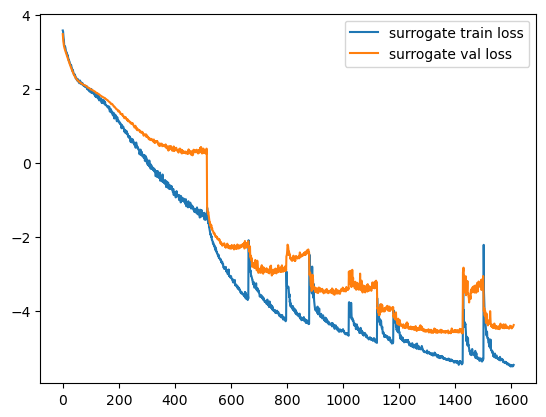

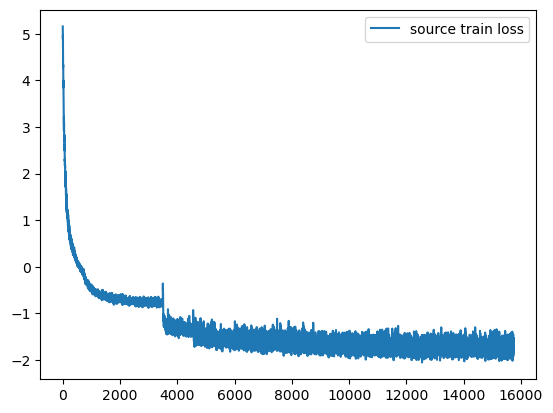

In [22]:
start_idx=0
plt.plot(train_losses[start_idx:], label=f"surrogate train loss")
plt.plot(val_losses[start_idx:], label=f"surrogate val loss")
plt.legend()
plt.show()

plt.plot(train_source_losses[start_idx:], label=f"source train loss")
plt.legend()
plt.show()

In [23]:
results_df = pd.DataFrame(
    {
        "surro_c2sts": surro_c2sts,
        "surro_swds": surro_swds,

        "source_simu_pf_swds": source_simu_pf_swds,
        "source_simu_pf_c2sts": source_simu_pf_c2sts,
        "source_surro_pf_c2sts": source_surro_pf_c2sts,

        "source_c2sts": source_c2sts,
        "source_entropies": source_entropies,
        
    }
)

results_df

,surro_c2sts,surro_swds,source_simu_pf_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_c2sts,source_entropies
0,0.79935,0.478820,0.103146,0.69340,0.72350,0.96875,3.852542
1,0.71880,0.219827,0.051052,0.63415,0.68710,0.94100,3.710628
2,0.62380,0.087549,0.029052,0.59160,0.59845,0.91185,3.693071
3,0.58045,0.061509,0.025082,0.56435,0.55430,0.89280,3.694156
4,0.55425,0.049832,0.031241,0.54565,0.54355,0.87965,3.674756
5,0.53635,0.038181,0.022824,0.52900,0.53005,0.87190,3.754240
6,0.53535,0.029461,0.021698,0.52910,0.52605,0.86830,3.803333
7,0.51365,0.030876,0.021441,0.50440,0.52020,0.85940,3.820401
8,0.50745,0.027537,0.025724,0.50750,0.51145,0.85500,3.826741
9,0.50285,0.024192,0.021612,0.50145,0.50680,0.85590,3.896569


In [24]:
# save everything as a dataframe?
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
train_source_losses = np.array(train_source_losses)

save_numpy_csv(
    train_losses,
    file_name=f"{cfg.base.tag}_train_losses_surro.csv",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

save_numpy_csv(
    val_losses,
    file_name=f"{cfg.base.tag}_val_losses_surro.csv",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

save_numpy_csv(
    train_source_losses,
    file_name=f"{cfg.base.tag}_source_training_losses.csv",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

results_df.to_csv(os.path.join(cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_results_df.csv"), index=False)

In [25]:
expected_distance

0.016467256471514702

In [26]:
# torch.cuda.empty_cache()
!nvidia-smi

Mon Nov 18 15:49:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:DA:00.0 Off |                  N/A |
|  0%   42C    P8              13W / 250W |   6955MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--